# Generate pileup data for ATLAS using a GAN (Generative Adversarial Network)

In [2]:
#imports
import numpy as np
import pandas as pd
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.image import decode_jpeg
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
import os
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.gridspec as gridspec
from pyjet import cluster, DTYPE_PTEPM
from pyjet.testdata import get_event
from matplotlib.colors import LogNorm
from atlasgan import reco

In [4]:
normalization_constant = 487

#load in the data
local_path = os.getcwd()
file_path = "/towahid/mu20_normalized_train.npy"
data_path = local_path + file_path
data_full = np.load(data_path)

#determine how many samples to take
n_samples = 10**4
data = data_full[:n_samples]

for i in range(len(data)):
    for j in range(len(data[i])):
        for k in range(len(data[i][j])):
            data[i][j][k] = data[i][j][k] * normalization_constant

In [6]:
#construct jets
jets = reco.reconstruct_events(data)

##### Let's plot some of the training data

In [7]:
#Wahid's draw_image function
def draw_image(x, vmin=None, vmax=None, xlabel='$\eta$', ylabel='$\phi$',
               draw_cbar=True, ax=None, figsize=(5,4), **kwargs):
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    cax = ax.imshow(x.T, extent=[-2.5, 2.5, -3.15, 3.15],
                    norm=LogNorm(vmin, vmax), aspect='auto',
                    origin='lower', **kwargs)
    if draw_cbar:
        cbar = plt.gcf().colorbar(cax, ax=ax)
        cbar.set_label('Energy')
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

### Plot Individual Events

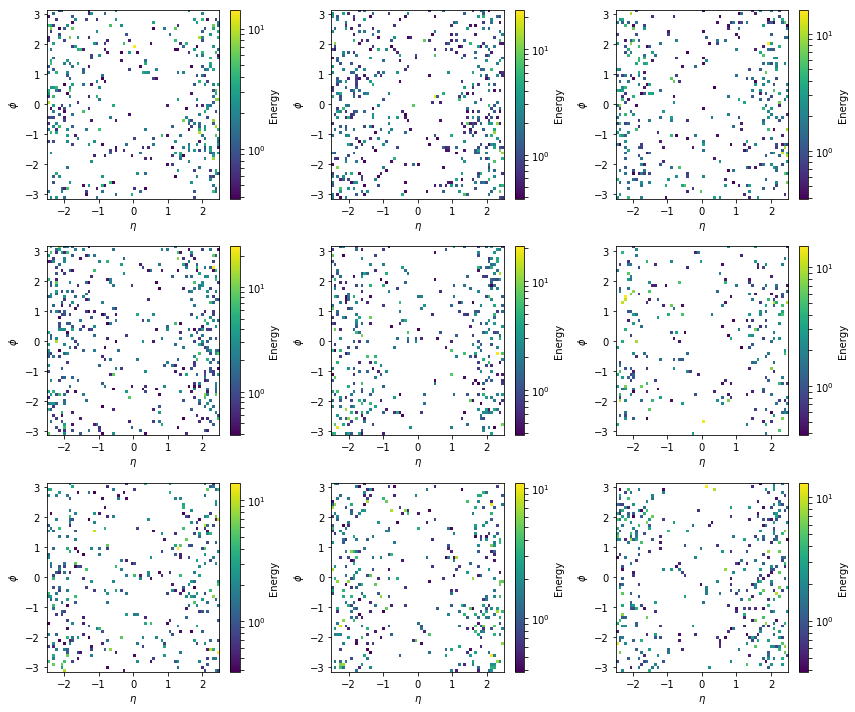

In [8]:
#Populate a list with 9 events from a chosen part of the data set (chosen via sample_seed)
sample_seed = 2
sample_events = []
for i in range(sample_seed, sample_seed+9):
    sample_events.append(data[i])

#Plot the events stored in sample_events using draw_image
fig, axs = plt.subplots(3,3, figsize=(12,10))
for i,ax in enumerate(axs.flatten()):
    draw_image(sample_events[i], ax=ax)
plt.tight_layout()

### Plot the properties of the jets

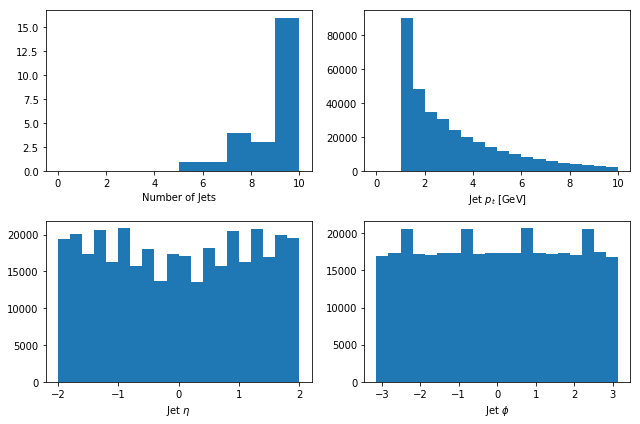

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(9,6))

#number of jets
jetCount = jets.groupby('event').size()
ax1.hist(jetCount, bins=10, range=(0,10))
ax1.set_xlabel('Number of Jets')

#jet pt
ax2.hist(jets.pt, bins=20, range=(0,10))
ax2.set_xlabel('Jet $p_t$ [GeV]')

#jet eta
ax3.hist(jets.eta, bins= 20, range=(-2,2))
ax3.set_xlabel('Jet $\eta$')

#jet phi
ax4.hist(jets.phi, bins= 20, range= (-np.pi, np.pi))
ax4.set_xlabel('Jet $\phi$')

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

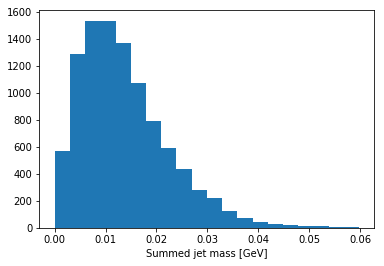

<Figure size 432x288 with 0 Axes>

In [10]:
# Sum of jet mass
sumMass = jets.groupby('event').apply(lambda x: x.m.sum())
plt.hist(sumMass*1e-3, bins=20)
plt.xlabel('Summed jet mass [GeV]');

plt.figure()